In [1]:
import numpy as np
import os
import pandas as pd
from pandas import ExcelWriter
import matplotlib.pyplot as plt
import openpyxl
import matplotlib as mpl
import scipy as sp
from scipy import stats
from scipy import signal
from scipy import fft
from scipy import io
from scipy import interpolate
from scipy import optimize
from scipy import linalg
from scipy import integrate
from scipy.fft import dct

mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = [
    r'\usepackage{textcomp}',
    r'\usepackage{wasysym}']
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.size'] = 22
mpl.rcParams['font.family'] = 'STIXGeneral'

saveFigs = False

import sys
import os

sys.path.append('../../')
sys.path.append('../')

from GetCoreData_fct import GetCoreData
from BackDiffuse_LT import BackDiffuse
from Interpolation_Class import Interpolation
from HL_AnalyticThea_class import HL_Thea
from DiffusionProfiles_calculations import DiffusionLength
from transforms import transforms
from Decon import SpectralDecon
from sigmaSolver import sigma_Solver
from SignalAttenuation import Attenuation, AnnualLayerThick


# Annual Layer Thickness Estimation

In [131]:
sites = ['SiteA', 'SiteB', 'SiteD', 'SiteE', 'SiteG']

CoresSpecs = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/CoreSpecs.txt', ',')

dTambs = np.zeros(len(sites))
dLakis = np.zeros(len(sites))

for i in range(len(sites)):
    coreNames = CoresSpecs['CoreName']

    core_idx = coreNames[CoresSpecs['CoreName'] == sites[i]].index[0]
    CoreSpecs = CoresSpecs.iloc[core_idx]
    dTambs[i] = CoreSpecs['dTamb']
    dLakis[i] = CoreSpecs['dLaki']

In [148]:
pathResults = '/home/thea/MesterTesen/Analysis/ResultsGeneration/ResultsData/'
data = pd.read_csv(pathResults + site + '_ALT_FullCore_Pshift_50.csv')


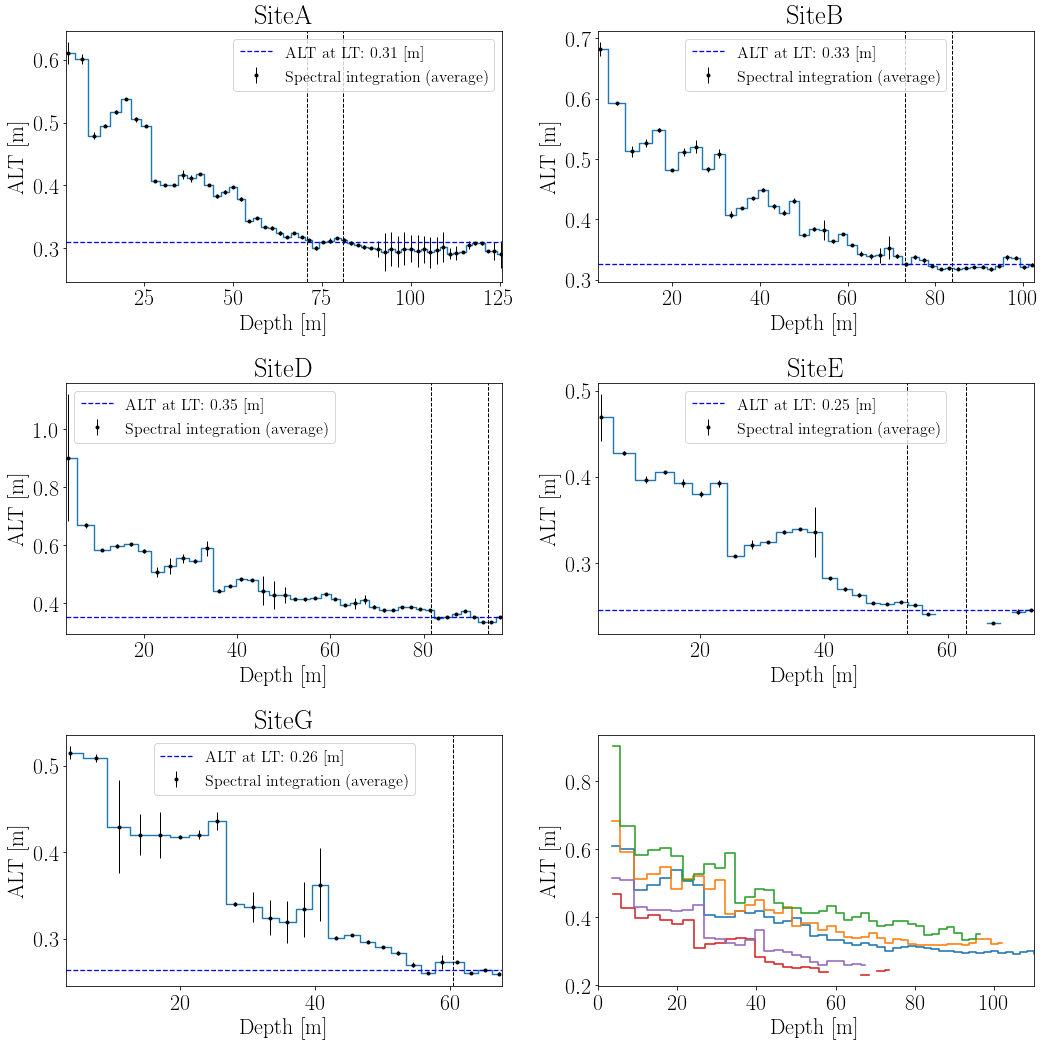

In [150]:
fig, axs = plt.subplots(int(np.ceil(len(sites)/2)),2,figsize=(15,15))
plt.close()

for i,ax in zip(range(len(sites)),axs.flatten()):
    site = sites[i]

    data = pd.read_csv(pathResults + site + '_ALT_FullCore_Pshift_50.csv')
    lMean = data['lMean']
    lStd = data['lStd']
    secs = data['depth']
    
    l_LT = np.mean(lMean[(secs >= dTambs[i]) & (secs <= dLakis[i])])
    
    ax.step(secs, lMean, where='mid', lw=1.4)
    ax.errorbar(secs, lMean, lStd, c='k', fmt='.', lw=1, label='Spectral integration (average)')
    ax.set(xlim=(min(secs)-0.5, max(secs)+0.5), xlabel='Depth [m]', ylabel='ALT [m]', title=site)
    ax.axvline(dLakis[i], lw=1, ls='--', c='k')
    ax.axvline(dTambs[i], lw=1, ls='--', c='k')
    ax.axhline(l_LT, lw=1.3, ls='--', c='b', label = f'ALT at LT: {l_LT:.2f} [m]')
    ax.legend(fontsize=16)
    
    
    
    axs.flatten()[-1].step(secs, lMean, where='mid', lw=1.6)
    #axs.flatten()[-1].errorbar(secs, lMean, lStd, c='k', fmt='.', lw=1, label='Spectral integration (average)', alpha=0.6)
    axs.flatten()[-1].set(xlim=(0,110), xlabel='Depth [m]', ylabel='ALT [m]')
fig.tight_layout()
fig

In [75]:
np.savetxt(site+'_test.csv', allData, delimiter=",", header="fDCT,fNDCT,fFFT,lDCT,lNDCT,lFFT,lMean,lStd,depth", comments='')

# Spectral Transforms Effect on Diffusion Length

# N Peaks vs. Diffusion Length

# Interpolation bf. vs. Diffusion Length

# Interpolation af. vs. Diffusion Length

# sigma_const vs. sigma(z)

# No Constraints vs. Constraints

# LT location distributions

# Final sigma estimates, based on previous conclusions